<a href="https://colab.research.google.com/github/sushirito/ArsenicFR/blob/main/MBComparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab-ready
!pip install colour-science


In [2]:
# === Colab setup ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


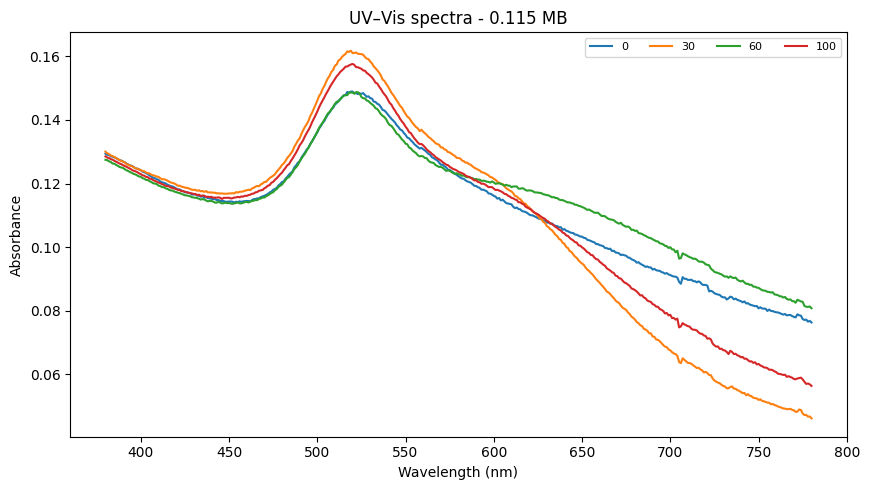

[0.115 MB] concentrations in chip row: 0.0 .. 100.0 (N=201)  RGB range 0.540-0.657


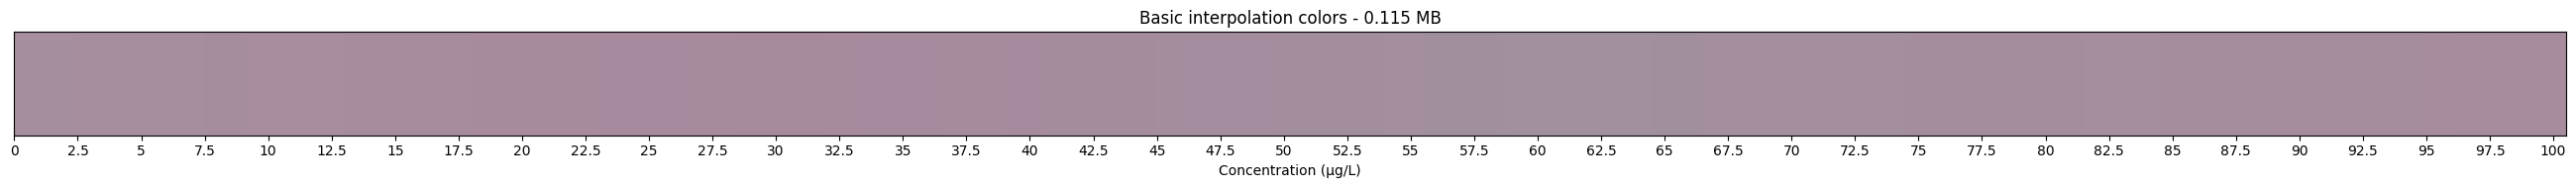

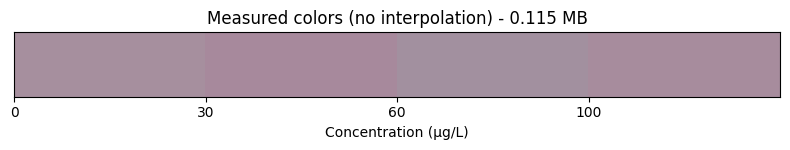

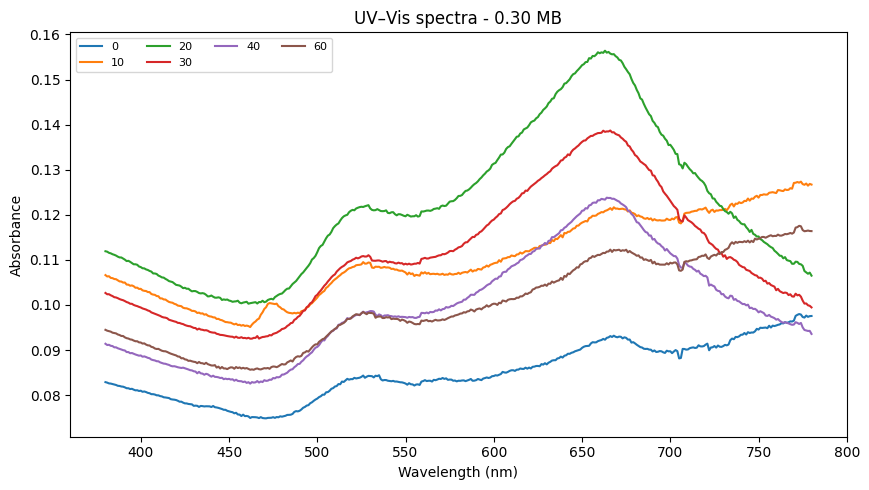

[0.30 MB] concentrations in chip row: 0.0 .. 60.0 (N=121)  RGB range 0.556-0.734


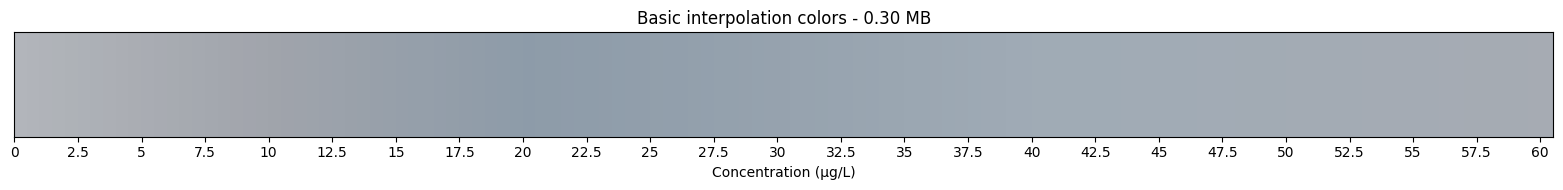

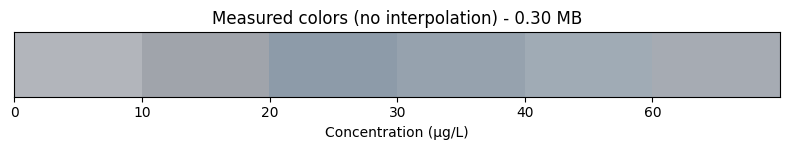

In [10]:
# Colab-ready: Plot spectra + basic-interpolation color chips for BOTH datasets (no model)
# Uses CIE 1931 2° CMFs and D65 via colour-science

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS

# ========= Inputs =========
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0          # controls strength of T = 10^(-ABS_MULT*A)
LABEL_EVERY = 5
GRID_STEP = 0.5         # µg/L step for the basic interpolation chip row

# ========= Colour setup =========
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

def spectra_to_rgb(wavelengths, absorbance):
    """One perceived color from a full spectrum under D65."""
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns, "CSV must have 'Wavelength'"
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")

    # keep visible only
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()

    # keep only numeric concentration columns
    conc_vals = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            conc_vals.append(float(c))
        except:
            pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    conc_cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]

    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in conc_cols], axis=1)  # [λ, K]
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def basic_interp_colors(wl, conc_vals, A, step=GRID_STEP):
    """
    Build a chip row by linearly interpolating absorbance across concentration
    onto a uniform grid, then converting each spectrum to one sRGB color.
    """
    c_grid = np.round(np.arange(float(conc_vals.min()), float(conc_vals.max()) + 1e-12, float(step)), 6)
    # interpolate per wavelength
    A_basic = np.vstack([
        np.interp(c_grid, conc_vals, A[i, :])
        for i in range(A.shape[0])
    ])  # [λ, N]
    # color per concentration
    rgb = np.vstack([spectra_to_rgb(wl, A_basic[:, j]) for j in range(A_basic.shape[1])])  # [N,3]
    return c_grid, rgb

def plot_spectra(wl, conc_vals, A, title):
    plt.figure(figsize=(8.8, 5.0))
    for j, c in enumerate(conc_vals):
        label = str(int(c)) if float(c).is_integer() else f"{c}"
        plt.plot(wl, A[:, j], label=label)
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absorbance")
    plt.title(f"UV–Vis spectra - {title}")
    plt.legend(ncol=4, fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_chip_row(concs, rgb, title):
    N = len(concs)
    img = rgb[np.newaxis, :, :]  # 1 x N x 3
    plt.figure(figsize=(max(10, 0.13*N), 2.0))
    plt.imshow(img, aspect="auto", extent=[0, N, 0, 1])
    plt.yticks([])
    ticks = list(range(0, N, LABEL_EVERY))
    plt.xticks(ticks, [f"{concs[i]:g}" for i in ticks])
    plt.xlabel("Concentration (µg/L)")
    plt.title(f"Basic interpolation colors - {title}")
    plt.tight_layout()
    plt.show()
    # Extra: individual measured concentration chips (no interpolation)
    rgb_measured = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    plt.figure(figsize=(max(8, 0.13*len(conc_vals)), 1.6))
    plt.imshow(rgb_measured[np.newaxis, :, :], aspect="auto",
               extent=[0, len(conc_vals), 0, 1])
    plt.yticks([])
    plt.xticks(range(len(conc_vals)),
               [f"{c:g}" for c in conc_vals])
    plt.xlabel("Concentration (µg/L)")
    plt.title(f"Measured colors (no interpolation) - {label}")
    plt.tight_layout()
    plt.show()


# ========= Run for both datasets =========
for label, path in FILES.items():
    wl, conc_vals, A = load_measured_csv(path)
    plot_spectra(wl, conc_vals, A, label)

    c_grid, rgb = basic_interp_colors(wl, conc_vals, A, step=GRID_STEP)
    # quick sanity
    print(f"[{label}] concentrations in chip row: {c_grid[0]} .. {c_grid[-1]} (N={len(c_grid)})  RGB range {rgb.min():.3f}-{rgb.max():.3f}")
    plot_chip_row(c_grid, rgb, label)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


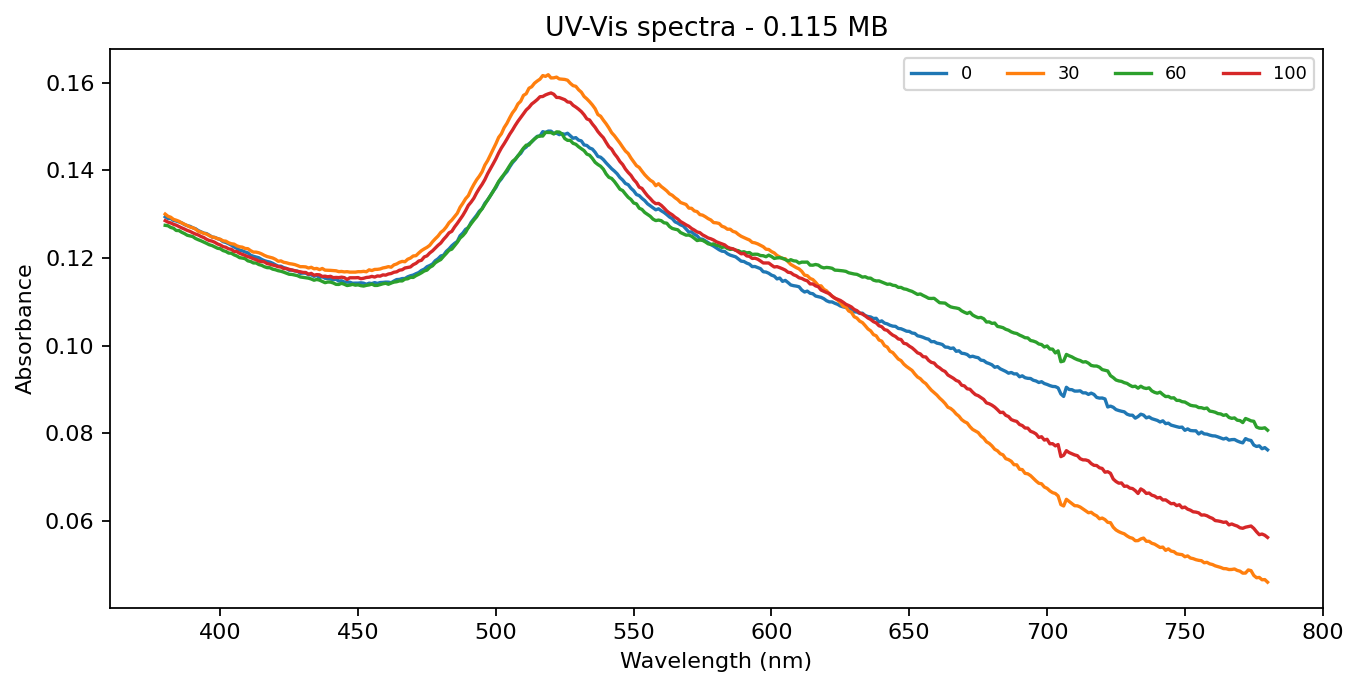

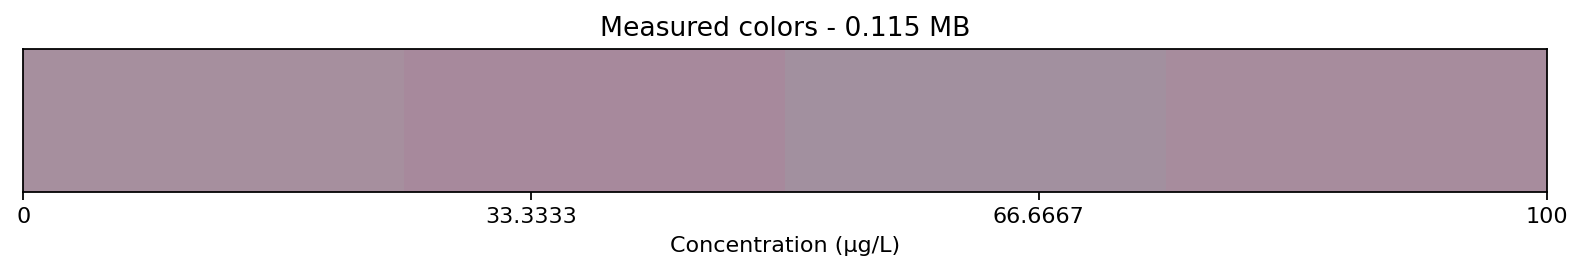

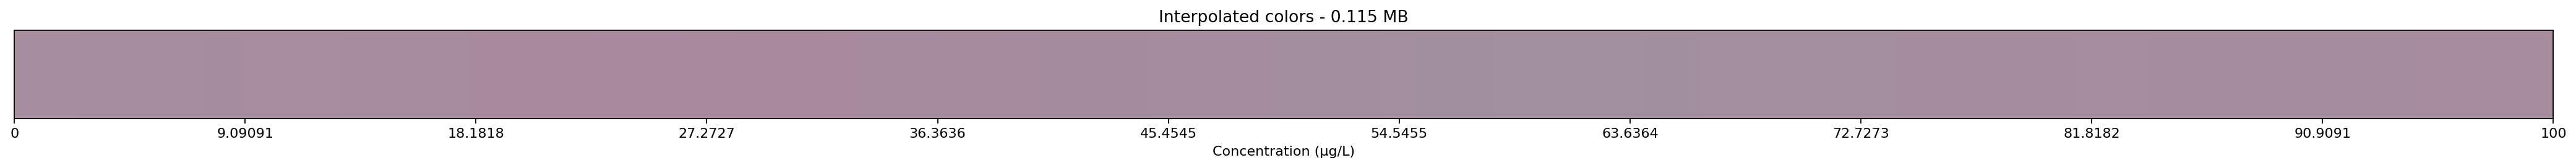

/tmp/ipython-input-137368958.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(dE, concs)) if len(dE) > 1 else 0.0


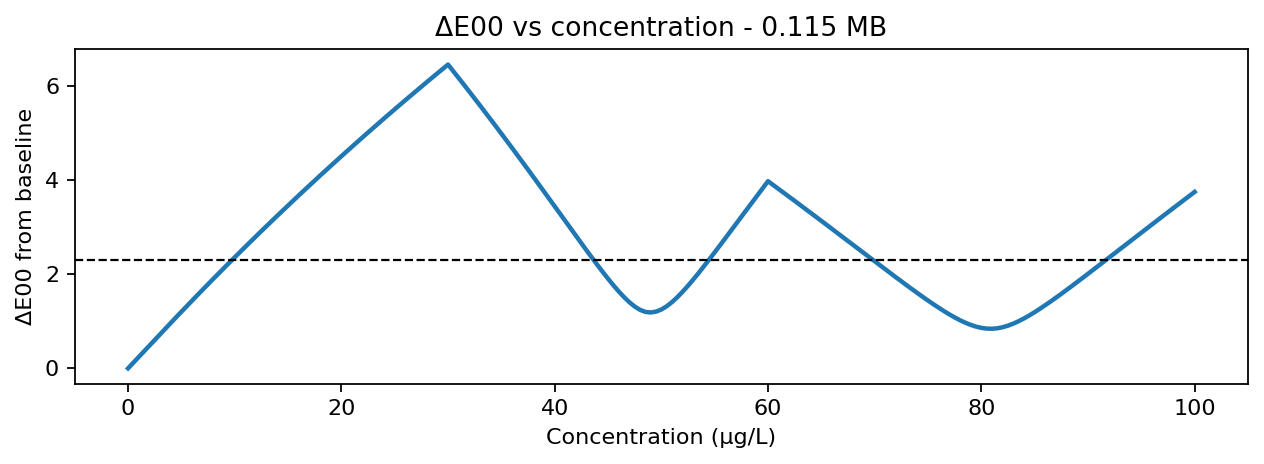

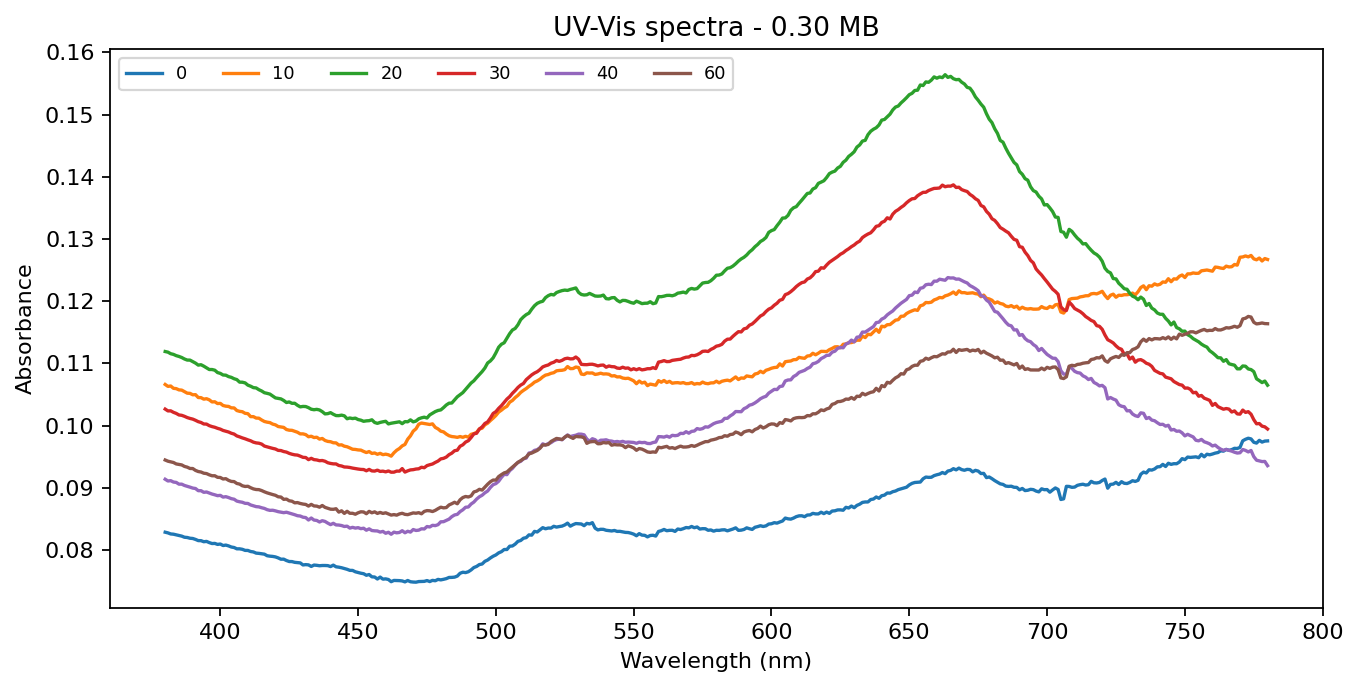

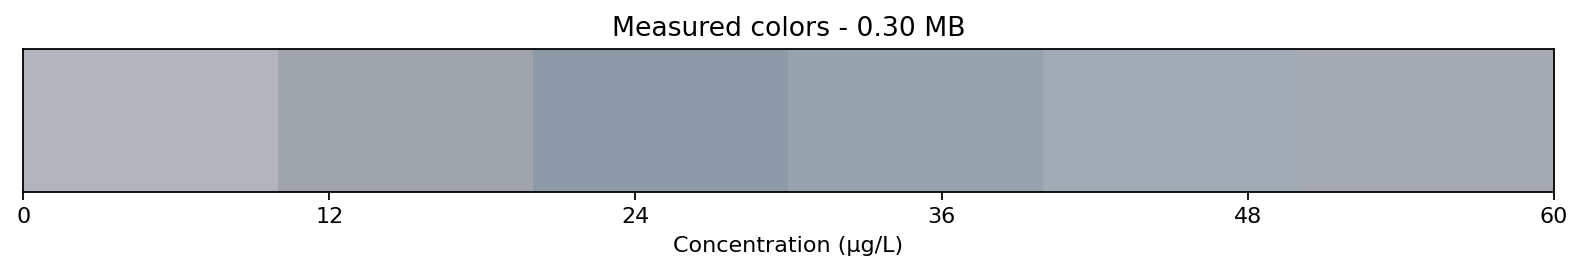

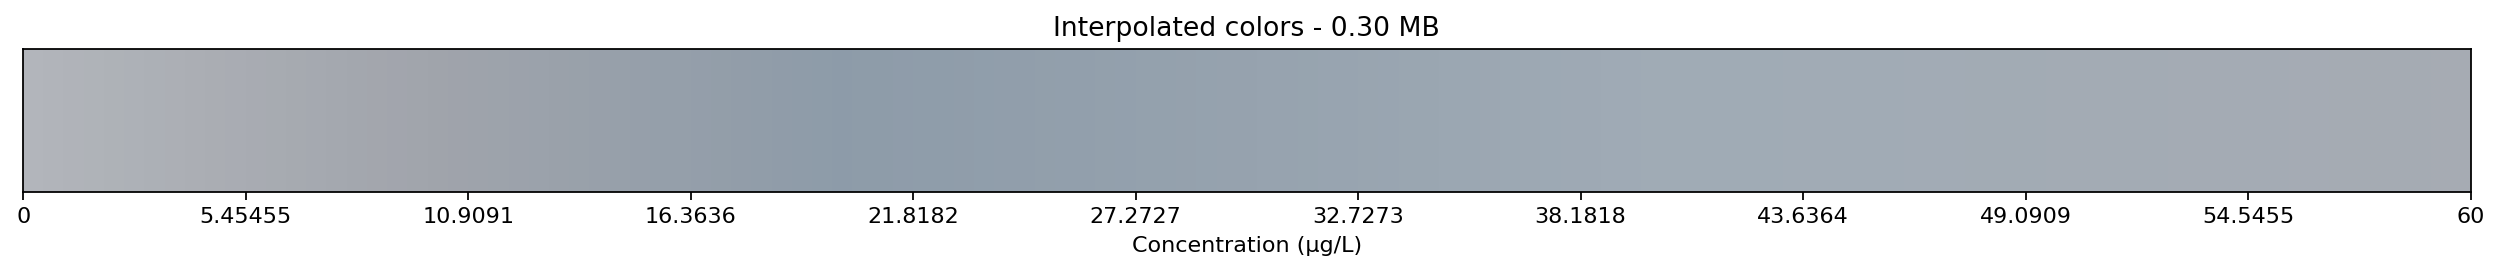

/tmp/ipython-input-137368958.py:112: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(dE, concs)) if len(dE) > 1 else 0.0


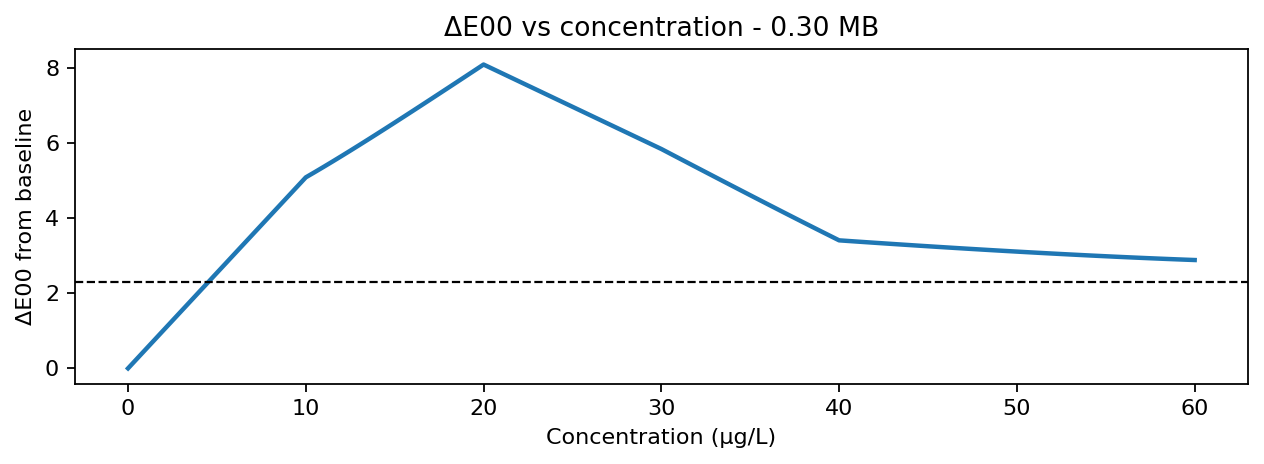


Phone-readout discriminability metrics (higher is better except c_detect):

Mix          | c_detect (µg/L) | min ΔE00 step |  monotone frac |     AUC-ΔE
---------------------------------------------------------------------------
0.115 MB     |              10 | -0.158 | 0.600 | 284.671
0.30 MB      |               5 | -0.124 | 0.333 | 269.090

Suggested winner: 0.30 MB


In [11]:
# Colab-ready: ΔE00 phone-readout metrics for 0.115 MB vs 0.30 MB
# It loads your CSVs, converts spectra to sRGB under D65, computes ΔE00 from the 0 sample,
# and prints: detection threshold, min step, monotone fraction, and AUC.


from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS
from colour.difference import delta_E
plt.rcParams["figure.dpi"] = 160

# ========= Inputs =========
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0           # controls T = 10^(-ABS_MULT*A)
GRID_STEP = 0.5          # concentration step for interpolation
JND = 2.3                 # ΔE00 threshold for "just noticeable"
LABEL_EVERY = 5

# ========= Colour setup =========
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

# ========= Helpers =========
def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns, "CSV must have a 'Wavelength' column"
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
    # visible only
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()

    # collect numeric concentration columns
    conc_vals = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            conc_vals.append(float(c))
        except:
            pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    conc_cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]

    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in conc_cols], axis=1)  # [λ, K]
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def spectra_to_rgb(wavelengths, absorbance):
    """
    Convert a full spectrum to one sRGB under D65 by using transmittance T = 10^(-k*A).
    """
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def basic_interp_colors(wl, conc_vals, A, step):
    c_grid = np.round(np.arange(float(conc_vals.min()),
                                float(conc_vals.max()) + 1e-12,
                                float(step)), 6)
    # interpolate per wavelength across concentration
    A_grid = np.vstack([
        np.interp(c_grid, conc_vals, A[i, :])
        for i in range(A.shape[0])
    ])  # [λ, N]
    rgb_grid = np.vstack([spectra_to_rgb(wl, A_grid[:, j]) for j in range(A_grid.shape[1])])  # [N,3]
    return c_grid, rgb_grid

# sRGB -> XYZ (D65) helper for white reference
def srgb_to_XYZ(rgb):
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    def inv_eotf(u):
        u = np.clip(u, 0, 1)
        return np.where(u <= 0.04045, u / 12.92, ((u + 0.055) / 1.055) ** 2.4)
    lin = inv_eotf(rgb)
    return (M @ lin.T).T

from colour import XYZ_to_Lab

def rgb_to_Lab(rgb_array, white_XYZ):
    XYZ = srgb_to_XYZ(rgb_array)
    return XYZ_to_Lab(XYZ, white_XYZ)

def evaluate_mix(concs, rgb):
    # use the minimum concentration as the baseline "before" sample
    idx0 = int(np.argmin(concs))
    white_XYZ = srgb_to_XYZ(rgb[idx0])
    Lab = rgb_to_Lab(rgb, white_XYZ)
    Lab0 = Lab[idx0][None, :]
    dE = delta_E(Lab, np.repeat(Lab0, len(Lab), axis=0), method="CIE 2000")

    # metrics
    if np.any(dE >= JND):
        detect_idx = np.argmax(dE >= JND)
        c_detect = float(concs[detect_idx])
    else:
        c_detect = float("inf")
    step_min = float(np.min(np.diff(dE))) if len(dE) > 1 else np.nan
    monotone_frac = float(np.mean(np.diff(dE) > 0)) if len(dE) > 1 else np.nan
    auc = float(np.trapz(dE, concs)) if len(dE) > 1 else 0.0
    return dict(c_detect=c_detect, step_min=step_min, monotone_frac=monotone_frac, auc=auc, dE=dE)

def plot_chip_row(concs, rgb, title):
    N = len(concs)
    img = rgb[np.newaxis, :, :]
    plt.figure(figsize=(max(10, 0.13*N), 1.8))
    plt.imshow(img, aspect="auto", extent=[concs[0], concs[-1], 0, 1])
    plt.yticks([])
    ticks = np.linspace(concs[0], concs[-1], num=min(12, N))
    plt.xticks(ticks, [f"{t:g}" for t in ticks])
    plt.xlabel("Concentration (µg/L)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_dE(concs, dE, title):
    plt.figure(figsize=(8, 3))
    plt.plot(concs, dE, lw=2)
    plt.axhline(JND, ls="--", color="k", lw=1)
    plt.xlabel("Concentration (µg/L)")
    plt.ylabel("ΔE00 from baseline")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ========= Run for both datasets =========
results = {}
for label, path in FILES.items():
    wl, conc_vals, A = load_measured_csv(path)

    # spectra plot
    plt.figure(figsize=(8.6, 4.4))
    for j, c in enumerate(conc_vals):
        lab = str(int(c)) if float(c).is_integer() else f"{c}"
        plt.plot(wl, A[:, j], label=lab)
    plt.xlabel("Wavelength (nm)"); plt.ylabel("Absorbance"); plt.title(f"UV-Vis spectra - {label}")
    plt.legend(ncol=6, fontsize=8); plt.tight_layout(); plt.show()

    # measured chips
    rgb_measured = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    plot_chip_row(conc_vals, rgb_measured, f"Measured colors - {label}")

    # interpolated chips
    c_grid, rgb_grid = basic_interp_colors(wl, conc_vals, A, step=GRID_STEP)
    plot_chip_row(c_grid, rgb_grid, f"Interpolated colors - {label}")

    # metrics
    res = evaluate_mix(c_grid, rgb_grid)
    results[label] = res
    # dE plot
    plot_dE(c_grid, res["dE"], f"ΔE00 vs concentration - {label}")

# ========= Print summary table =========
print("\nPhone-readout discriminability metrics (higher is better except c_detect):\n")
print(f"{'Mix':<12} | {'c_detect (µg/L)':>15} | {'min ΔE00 step':>13} | {'monotone frac':>14} | {'AUC-ΔE':>10}")
print("-"*75)
for k, v in results.items():
    cdet = "∞" if np.isinf(v['c_detect']) else f"{v['c_detect']:.3g}"
    print(f"{k:<12} | {cdet:>15} | {v['step_min']:.3f} | {v['monotone_frac']:.3f} | {v['auc']:.3f}")

# ========= Winner suggestion =========
def winner_by(res_dict):
    # simple lexicographic rule: lower c_detect, then higher min step, then higher monotone_frac, then higher AUC
    items = list(res_dict.items())
    def key_fn(item):
        name, r = item
        c = r['c_detect'] if np.isfinite(r['c_detect']) else 1e9
        return (c, -r['step_min'], -r['monotone_frac'], -r['auc'])
    items.sort(key=key_fn)
    return items[0][0]

print("\nSuggested winner:", winner_by(results))


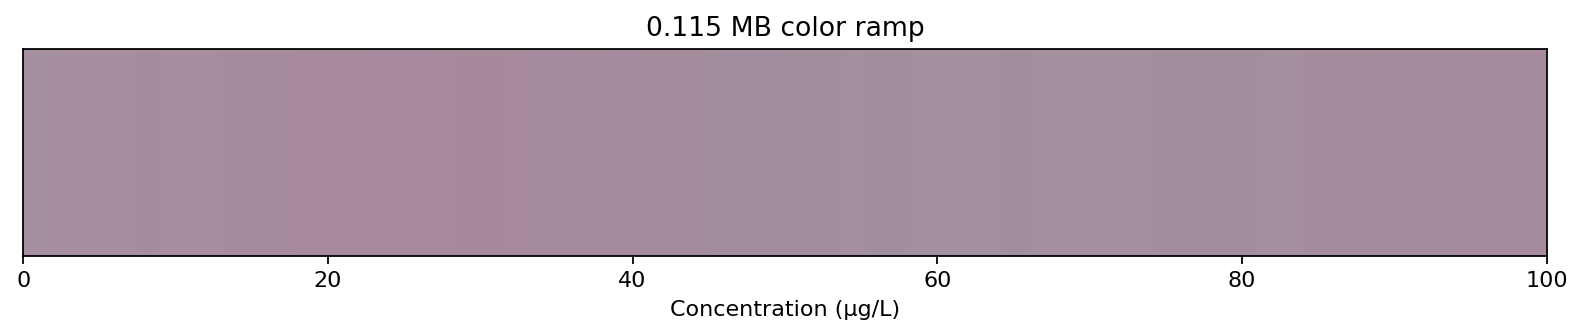

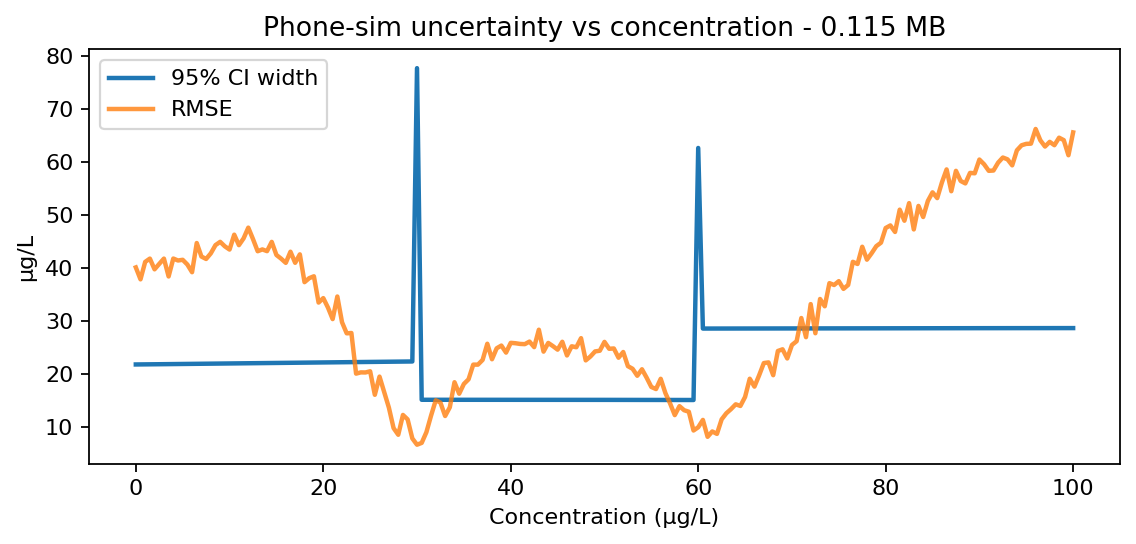

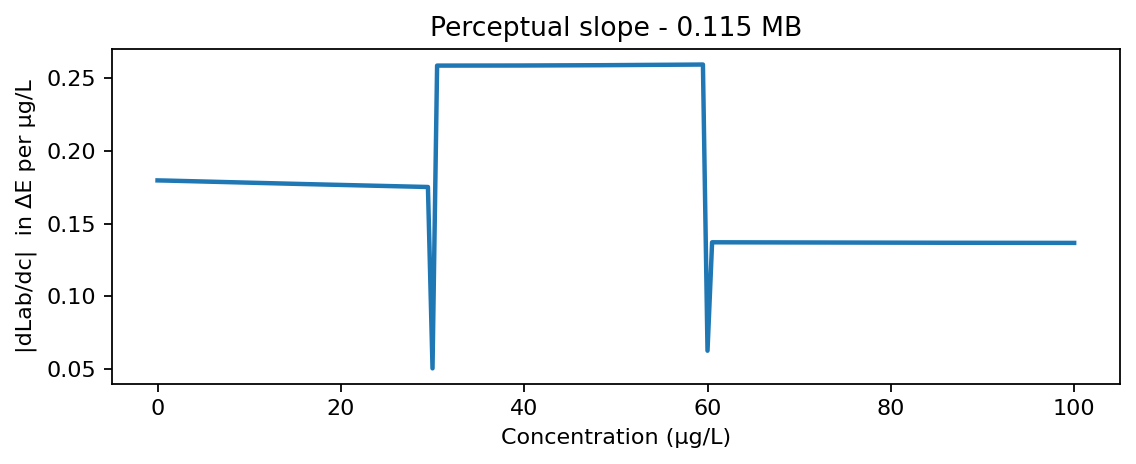

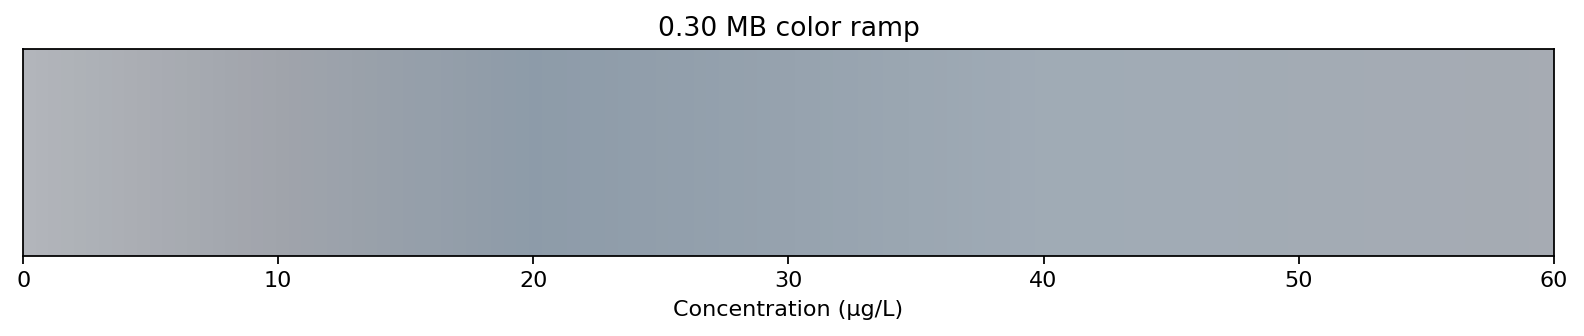

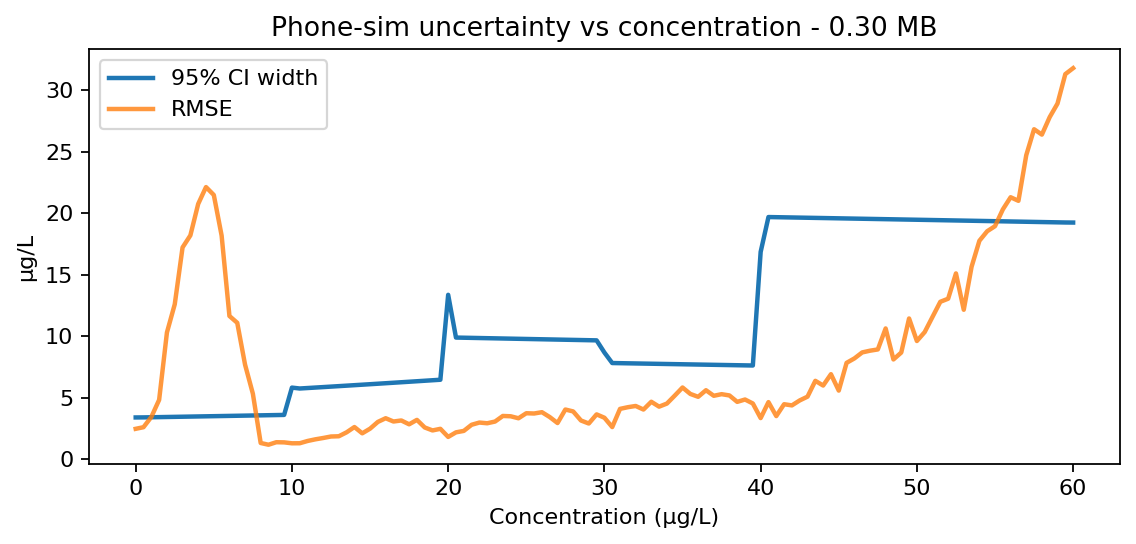

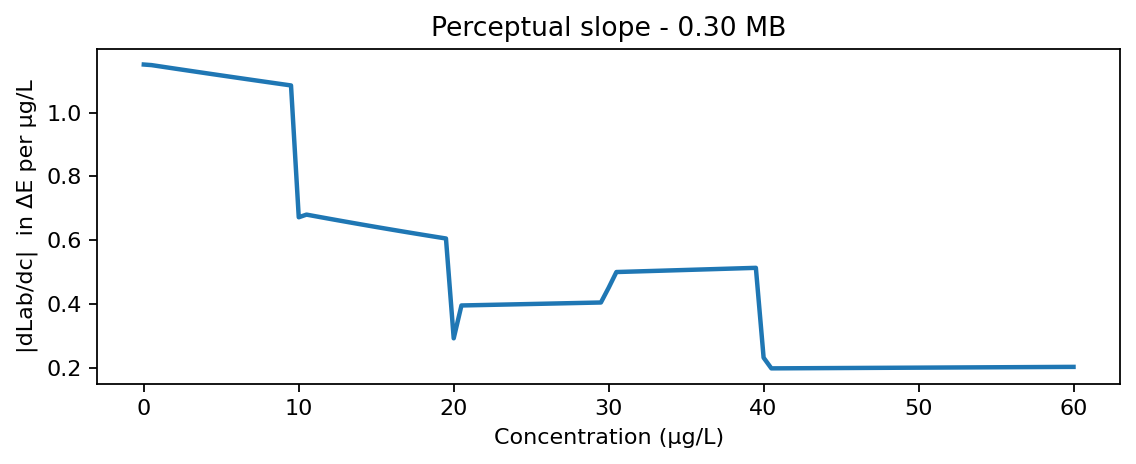


Phone-sim metrics in your range:

Mix          |  median CI |   worst CI |  median RMSE |  worst RMSE
-----------------------------------------------------------------
0.115 MB     | 22.2 | 77.6 | 30.4 | 66.2
0.30 MB      | 9.67 | 19.7 | 4.65 | 31.8

Suggested winner: 0.30 MB


In [12]:
# Phone-simulator for MB 0.115 and MB 0.30
# Confidence is based on local Lab slope vs a small perceptual noise
# Outputs: uncertainty plots, RMSE plots, and summary metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS
from colour import XYZ_to_Lab
plt.rcParams["figure.dpi"] = 160

# ===== Inputs =====
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0
GRID_STEP = 0.5            # interpolate to a fine grid
SIGMA_JND = 1.0            # phone Lab noise in ΔE units
N_SIMS = 300               # per grid point
RANGE_FOR_DECISION = None  # None uses full range, or tuple like (10, 60)

# ===== Colour setup =====
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

# ===== Helpers =====
def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()

    conc_vals = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            conc_vals.append(float(c))
        except:
            pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    conc_cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in conc_cols], axis=1)
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def spectra_to_rgb(wavelengths, absorbance):
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def srgb_to_XYZ(rgb):
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    def inv_eotf(u):
        u = np.clip(u, 0, 1)
        return np.where(u <= 0.04045, u/12.92, ((u+0.055)/1.055)**2.4)
    lin = inv_eotf(rgb)
    return (M @ lin.T).T

def rgb_to_Lab_with_white(rgb_array, white_rgb):
    white_XYZ = srgb_to_XYZ(white_rgb)
    XYZ = srgb_to_XYZ(rgb_array)
    return XYZ_to_Lab(XYZ, white_XYZ)

def build_curve(wl, conc_vals, A, step=GRID_STEP):
    # measured RGB
    rgb_meas = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    # use lowest conc as white reference
    idx0 = int(np.argmin(conc_vals))
    Lab_meas = rgb_to_Lab_with_white(rgb_meas, rgb_meas[idx0])

    # interpolate A over concentration to a fine grid, then map to Lab
    c_grid = np.round(np.arange(conc_vals.min(), conc_vals.max()+1e-9, step), 6)
    A_grid = np.vstack([np.interp(c_grid, conc_vals, A[i, :]) for i in range(A.shape[0])])
    rgb_grid = np.vstack([spectra_to_rgb(wl, A_grid[:, j]) for j in range(A_grid.shape[1])])
    Lab_grid = rgb_to_Lab_with_white(rgb_grid, rgb_meas[idx0])

    # arc length coordinate along the curve
    dLab = np.linalg.norm(np.diff(Lab_grid, axis=0), axis=1)
    s = np.concatenate([[0.0], np.cumsum(dLab)])  # same length as c_grid

    # local slope magnitude |dLab/dc|
    dc = np.gradient(c_grid)
    dLabdc = np.linalg.norm(np.gradient(Lab_grid, axis=0), axis=1) / (dc + 1e-12)

    return dict(c_grid=c_grid, Lab_grid=Lab_grid, rgb_grid=rgb_grid,
                s=s, dLabdc=dLabdc, Lab0=Lab_grid[np.argmin(c_grid)])

def project_to_curve(Lab_obs, Lab_curve):
    # nearest neighbor along the discrete curve
    idx = np.argmin(np.linalg.norm(Lab_curve - Lab_obs[None, :], axis=1))
    return idx

def simulate_phone(curve, sigma_jnd=SIGMA_JND, n_sims=N_SIMS, use_range=RANGE_FOR_DECISION):
    c = curve["c_grid"]
    Lab = curve["Lab_grid"]
    dLabdc = curve["dLabdc"]

    if use_range is not None:
        lo, hi = use_range
        mask = (c >= lo) & (c <= hi)
    else:
        mask = np.ones_like(c, dtype=bool)

    ests = []
    ci95 = []
    rmse = []
    for i in range(len(c)):
        if not mask[i]:
            ests.append(np.nan); ci95.append(np.nan); rmse.append(np.nan); continue
        # simulate N noisy phone reads at this true concentration
        Lab_true = Lab[i]
        noise = np.random.normal(0.0, sigma_jnd, size=(n_sims, 3))  # ΔE-like isotropic noise
        Lab_noisy = Lab_true[None, :] + noise
        idxs = [project_to_curve(Lab_noisy[k], Lab) for k in range(n_sims)]
        c_hat = c[idxs]
        ests.append(np.median(c_hat))
        rmse.append(np.sqrt(np.mean((c_hat - c[i])**2)))

        # analytic CI using local slope: sigma_c ≈ sigma_Lab / |dLab/dc|
        sigma_c = sigma_jnd / max(dLabdc[i], 1e-9)
        ci95.append(1.96 * sigma_c * 2.0)  # total width

    return dict(c=c, est=np.array(ests), rmse=np.array(rmse), ci95=np.array(ci95),
                dLabdc=dLabdc, mask=mask)

def summarize(sim):
    m = sim["mask"]
    ci = sim["ci95"][m]
    rm = sim["rmse"][m]
    return dict(
        median_CI=np.nanmedian(ci),
        worst_CI=np.nanmax(ci),
        median_RMSE=np.nanmedian(rm),
        worst_RMSE=np.nanmax(rm),
    )

# ===== Run for both datasets =====
curves = {}
sims = {}
summaries = {}

for label, path in FILES.items():
    wl, conc_vals, A = load_measured_csv(path)
    curves[label] = build_curve(wl, conc_vals, A, step=GRID_STEP)
    sims[label] = simulate_phone(curves[label], SIGMA_JND, N_SIMS, RANGE_FOR_DECISION)
    summaries[label] = summarize(sims[label])

# ===== Plots =====
for label in FILES.keys():
    cur = curves[label]; sim = sims[label]
    c = cur["c_grid"]; Lab = cur["Lab_grid"]
    # 1) Color ramp with CI whiskers
    img = cur["rgb_grid"][np.newaxis, :, :]
    plt.figure(figsize=(10, 2.2))
    plt.imshow(img, aspect="auto", extent=[c[0], c[-1], 0, 1])
    plt.yticks([])
    plt.xlabel("Concentration (µg/L)")
    plt.title(f"{label} color ramp")
    plt.tight_layout(); plt.show()

    # 2) Uncertainty vs concentration
    plt.figure(figsize=(7.2, 3.5))
    plt.plot(c, sim["ci95"], lw=2, label="95% CI width")
    plt.plot(c, sim["rmse"], lw=2, label="RMSE", alpha=0.8)
    plt.ylabel("µg/L")
    plt.xlabel("Concentration (µg/L)")
    plt.title(f"Phone-sim uncertainty vs concentration - {label}")
    plt.legend(); plt.tight_layout(); plt.show()

    # 3) Slope magnitude plot
    plt.figure(figsize=(7.2, 3.0))
    plt.plot(c, cur["dLabdc"], lw=2)
    plt.ylabel("|dLab/dc|  in ΔE per µg/L")
    plt.xlabel("Concentration (µg/L)")
    plt.title(f"Perceptual slope - {label}")
    plt.tight_layout(); plt.show()

# ===== Print summary and choose winner =====
print("\nPhone-sim metrics in your range:\n")
print(f"{'Mix':<12} | {'median CI':>10} | {'worst CI':>10} | {'median RMSE':>12} | {'worst RMSE':>11}")
print("-"*65)
for k, v in summaries.items():
    print(f"{k:<12} | {v['median_CI']:.3g} | {v['worst_CI']:.3g} | {v['median_RMSE']:.3g} | {v['worst_RMSE']:.3g}")

def winner_by(summ):
    # prefer smaller worst CI, then smaller median CI
    items = list(summ.items())
    items.sort(key=lambda kv: (kv[1]['worst_CI'], kv[1]['median_CI'], kv[1]['worst_RMSE']))
    return items[0][0]

print("\nSuggested winner:", winner_by(summaries))


/tmp/ipython-input-2205641572.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


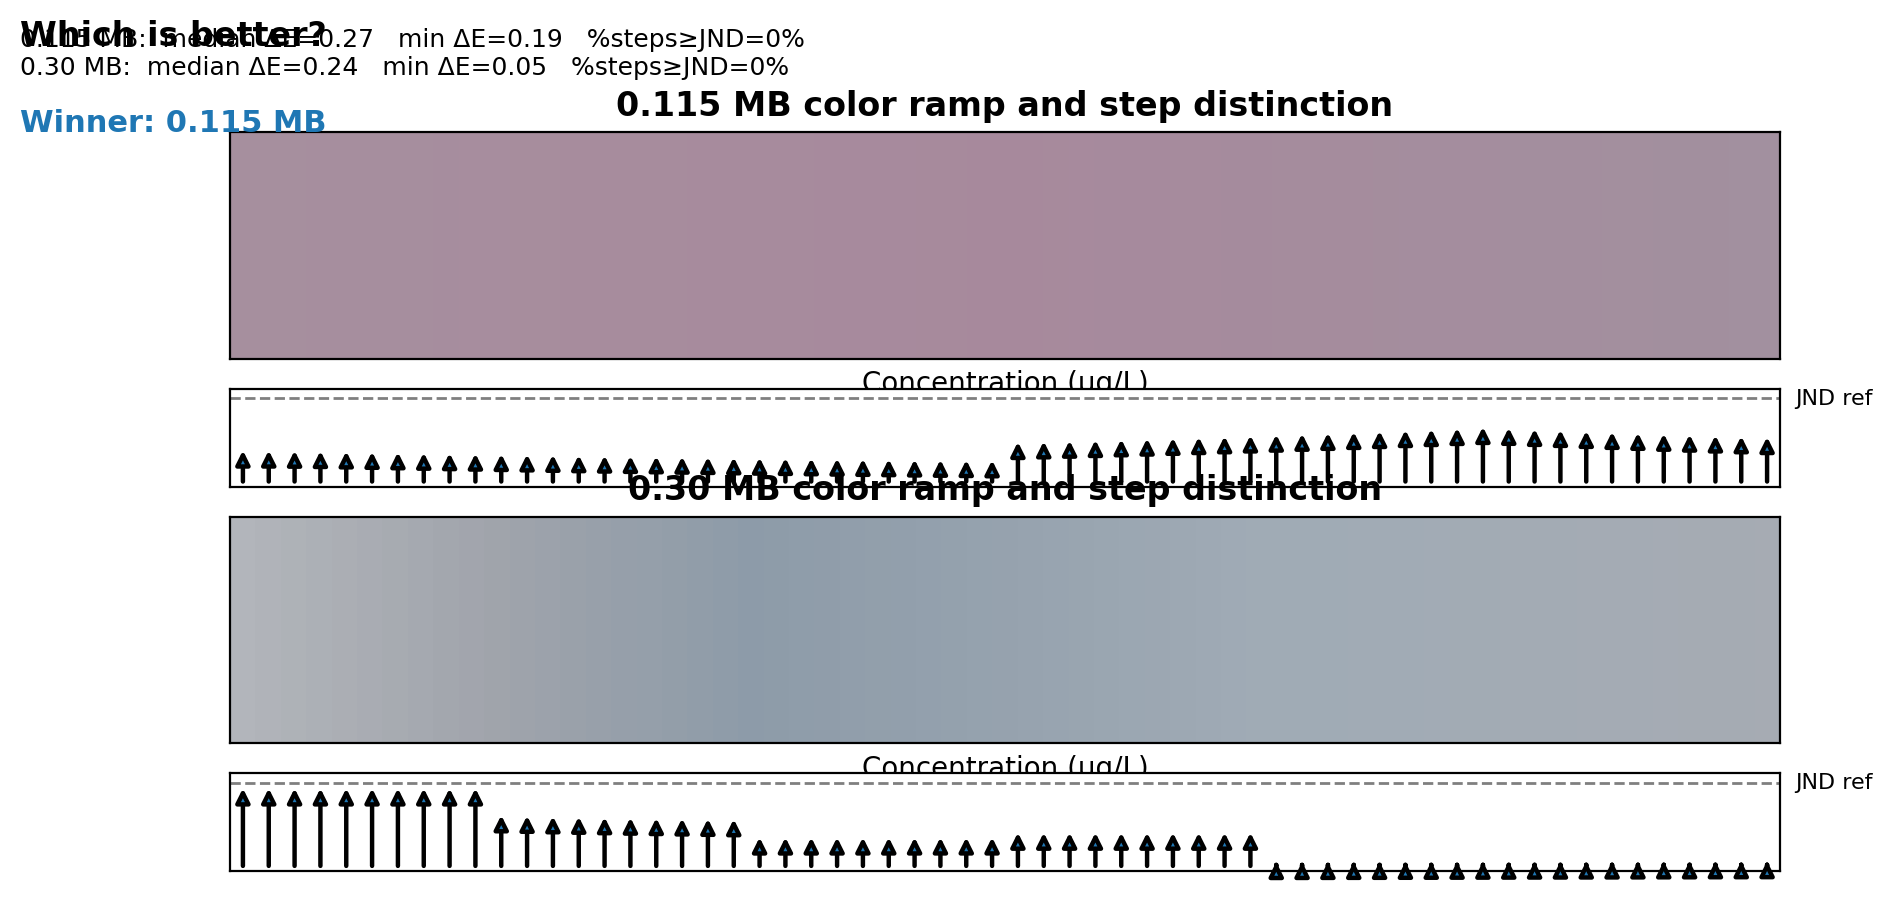

Adjacency distinction summary on common grid (higher is better):
Mix          |  median ΔE |   min ΔE | % steps ≥ JND
--------------------------------------------------
0.115 MB     |      0.267 |    0.186 |            0%
0.30 MB      |      0.241 |    0.055 |            0%


In [14]:
# Dual Color Strip with Distinction Arrows — common grid fix
# Forces both mixes to a shared concentration grid over the overlap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS
from colour import XYZ_to_Lab
from colour.difference import delta_E

plt.rcParams.update({"figure.dpi": 200, "font.size": 10})

# ========= Inputs =========
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0            # T = 10^(-ABS_MULT * A)
GRID_STEP = 1.0           # common step for both mixes
ARROW_MAX_PIX = 18
JND = 2.3

cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

# ========= Helpers =========
def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns, "CSV must have 'Wavelength'"
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()

    conc_vals = []
    for c in df.columns:
        if c == "Wavelength": continue
        try:
            conc_vals.append(float(c))
        except:
            pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    conc_cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in conc_cols], axis=1)
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def spectra_to_rgb(wavelengths, absorbance):
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def srgb_to_XYZ(rgb):
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    def inv_eotf(u):
        u = np.clip(u, 0, 1)
        return np.where(u <= 0.04045, u / 12.92, ((u + 0.055) / 1.055) ** 2.4)
    lin = inv_eotf(rgb)
    return (M @ lin.T).T

def rgb_to_Lab_with_white(rgb_array, white_rgb):
    white_XYZ = srgb_to_XYZ(white_rgb)
    XYZ = srgb_to_XYZ(rgb_array)
    return XYZ_to_Lab(XYZ, white_XYZ)

def interpolate_to_grid(wl, conc_vals, A, c_grid):
    # Interpolate absorbance at each wavelength onto the provided c_grid
    A_grid = np.vstack([
        np.interp(c_grid, conc_vals, A[i, :])
        for i in range(A.shape[0])
    ])
    rgb_grid = np.vstack([spectra_to_rgb(wl, A_grid[:, j]) for j in range(A_grid.shape[1])])
    return rgb_grid

def build_strip_on_common_grid(wl, conc_vals, A, c_grid):
    # White reference from lowest measured concentration
    rgb_meas = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    idx0 = int(np.argmin(conc_vals))
    rgb_grid = interpolate_to_grid(wl, conc_vals, A, c_grid)
    Lab_grid = rgb_to_Lab_with_white(rgb_grid, rgb_meas[idx0])
    dE_adj = delta_E(Lab_grid[:-1], Lab_grid[1:], method="CIE 2000")
    return rgb_grid, Lab_grid, dE_adj

def summarize_dE(dE_adj):
    return dict(
        median=float(np.median(dE_adj)) if len(dE_adj) else np.nan,
        min=float(np.min(dE_adj)) if len(dE_adj) else np.nan,
        pct_above_JND=float(100*np.mean(dE_adj >= JND)) if len(dE_adj) else np.nan
    )

# ========= Load both, build common grid =========
loaded = {}
for label, path in FILES.items():
    loaded[label] = load_measured_csv(path)

# Overlap range
min0, max0 = loaded["0.115 MB"][1].min(), loaded["0.115 MB"][1].max()
min1, max1 = loaded["0.30 MB"][1].min(),  loaded["0.30 MB"][1].max()
c_lo = max(min0, min1)
c_hi = min(max0, max1)
if not np.isfinite(c_lo) or not np.isfinite(c_hi) or c_hi <= c_lo:
    raise ValueError("No overlapping concentration range between the two mixes.")

# Common grid
c = np.round(np.arange(c_lo, c_hi + 1e-9, GRID_STEP), 6)

# Build both strips on the common grid
results = {}
for label in FILES.keys():
    wl, conc_vals, A = loaded[label]
    rgb_grid, Lab_grid, dE_adj = build_strip_on_common_grid(wl, conc_vals, A, c)
    results[label] = dict(c=c, rgb=rgb_grid, Lab=Lab_grid, dE=dE_adj, stats=summarize_dE(dE_adj))

# ========= Figure =========
labels = list(FILES.keys())
W = c[-1] - c[0]

# Normalize arrows by global max ΔE
global_max = max(results[labels[0]]["dE"].max(), results[labels[1]]["dE"].max())

fig_h = 4.8
fig = plt.figure(figsize=(10, fig_h))
gs = fig.add_gridspec(6, 1, hspace=0.3)

def draw_strip(ax_strip, ax_arrows, mix, title):
    rgb = mix["rgb"]; dE = mix["dE"]
    ax_strip.imshow(rgb[np.newaxis, :, :], aspect="auto", extent=[c[0], c[-1], 0, 1])
    ax_strip.set_yticks([]); ax_strip.set_xlim(c[0], c[-1]); ax_strip.set_title(title, weight="bold")
    ax_arrows.set_xlim(c[0], c[-1]); ax_arrows.set_ylim(0, 1); ax_arrows.set_yticks([]); ax_arrows.set_xticks([])
    mids = (c[:-1] + c[1:]) / 2.0
    h_frac = 0.9 * dE / max(global_max, 1e-9)
    for x, h in zip(mids, h_frac):
        ax_arrows.annotate("", xy=(x, h), xytext=(x, 0), arrowprops=dict(arrowstyle="-|>", lw=1.6))
    if len(dE):
        jnd_h = 0.9 * JND / max(global_max, 1e-9)
        jnd_h = np.clip(jnd_h, 0, 0.9)
        ax_arrows.axhline(jnd_h, ls="--", lw=1, color="k", alpha=0.5)
        ax_arrows.text(c[-1] + 0.01*W, jnd_h, "JND ref", va="center", fontsize=8)
    ax_strip.set_xlabel("Concentration (µg/L)")

ax1 = fig.add_subplot(gs[0:2, 0]); ax1a = fig.add_subplot(gs[2, 0], sharex=ax1)
draw_strip(ax1, ax1a, results[labels[0]], f"{labels[0]} color ramp and step distinction")

ax2 = fig.add_subplot(gs[3:5, 0], sharex=ax1); ax2a = fig.add_subplot(gs[5, 0], sharex=ax1)
draw_strip(ax2, ax2a, results[labels[1]], f"{labels[1]} color ramp and step distinction")

# Summary
s0, s1 = results[labels[0]]["stats"], results[labels[1]]["stats"]
txt = [
    f"{labels[0]}:  median ΔE={s0['median']:.2f}   min ΔE={s0['min']:.2f}   %steps≥JND={s0['pct_above_JND']:.0f}%",
    f"{labels[1]}:  median ΔE={s1['median']:.2f}   min ΔE={s1['min']:.2f}   %steps≥JND={s1['pct_above_JND']:.0f}%"
]
# Winner: higher min ΔE, tie-break by higher median ΔE, then higher %≥JND
def winner_name():
    k = lambda s: (s['min'], s['median'], s['pct_above_JND'])
    return labels[ int( k(s1) > k(s0) ) ]
winner = winner_name()

fig.text(0.02, 0.97, "Which is better?", fontsize=12, weight="bold")
fig.text(0.02, 0.94, "\n".join(txt), fontsize=9)
fig.text(0.02, 0.88, f"Winner: {winner}", fontsize=11, weight="bold", color="tab:blue")

plt.tight_layout()
plt.show()

# ========= Print table =========
print("Adjacency distinction summary on common grid (higher is better):")
print(f"{'Mix':<12} | {'median ΔE':>10} | {'min ΔE':>8} | {'% steps ≥ JND':>13}")
print("-"*50)
for lab in labels:
    s = results[lab]["stats"]
    print(f"{lab:<12} | {s['median']:>10.3f} | {s['min']:>8.3f} | {s['pct_above_JND']:>12.0f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1033386605.py:146: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap0 = cm.get_cmap("viridis")    # for 0.115 MB
/tmp/ipython-input-1033386605.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap("magma")      # for 0.30 MB
/tmp/ipython-input-1033386605.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])
/tmp/ipython-input-1033386605.py:194: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout

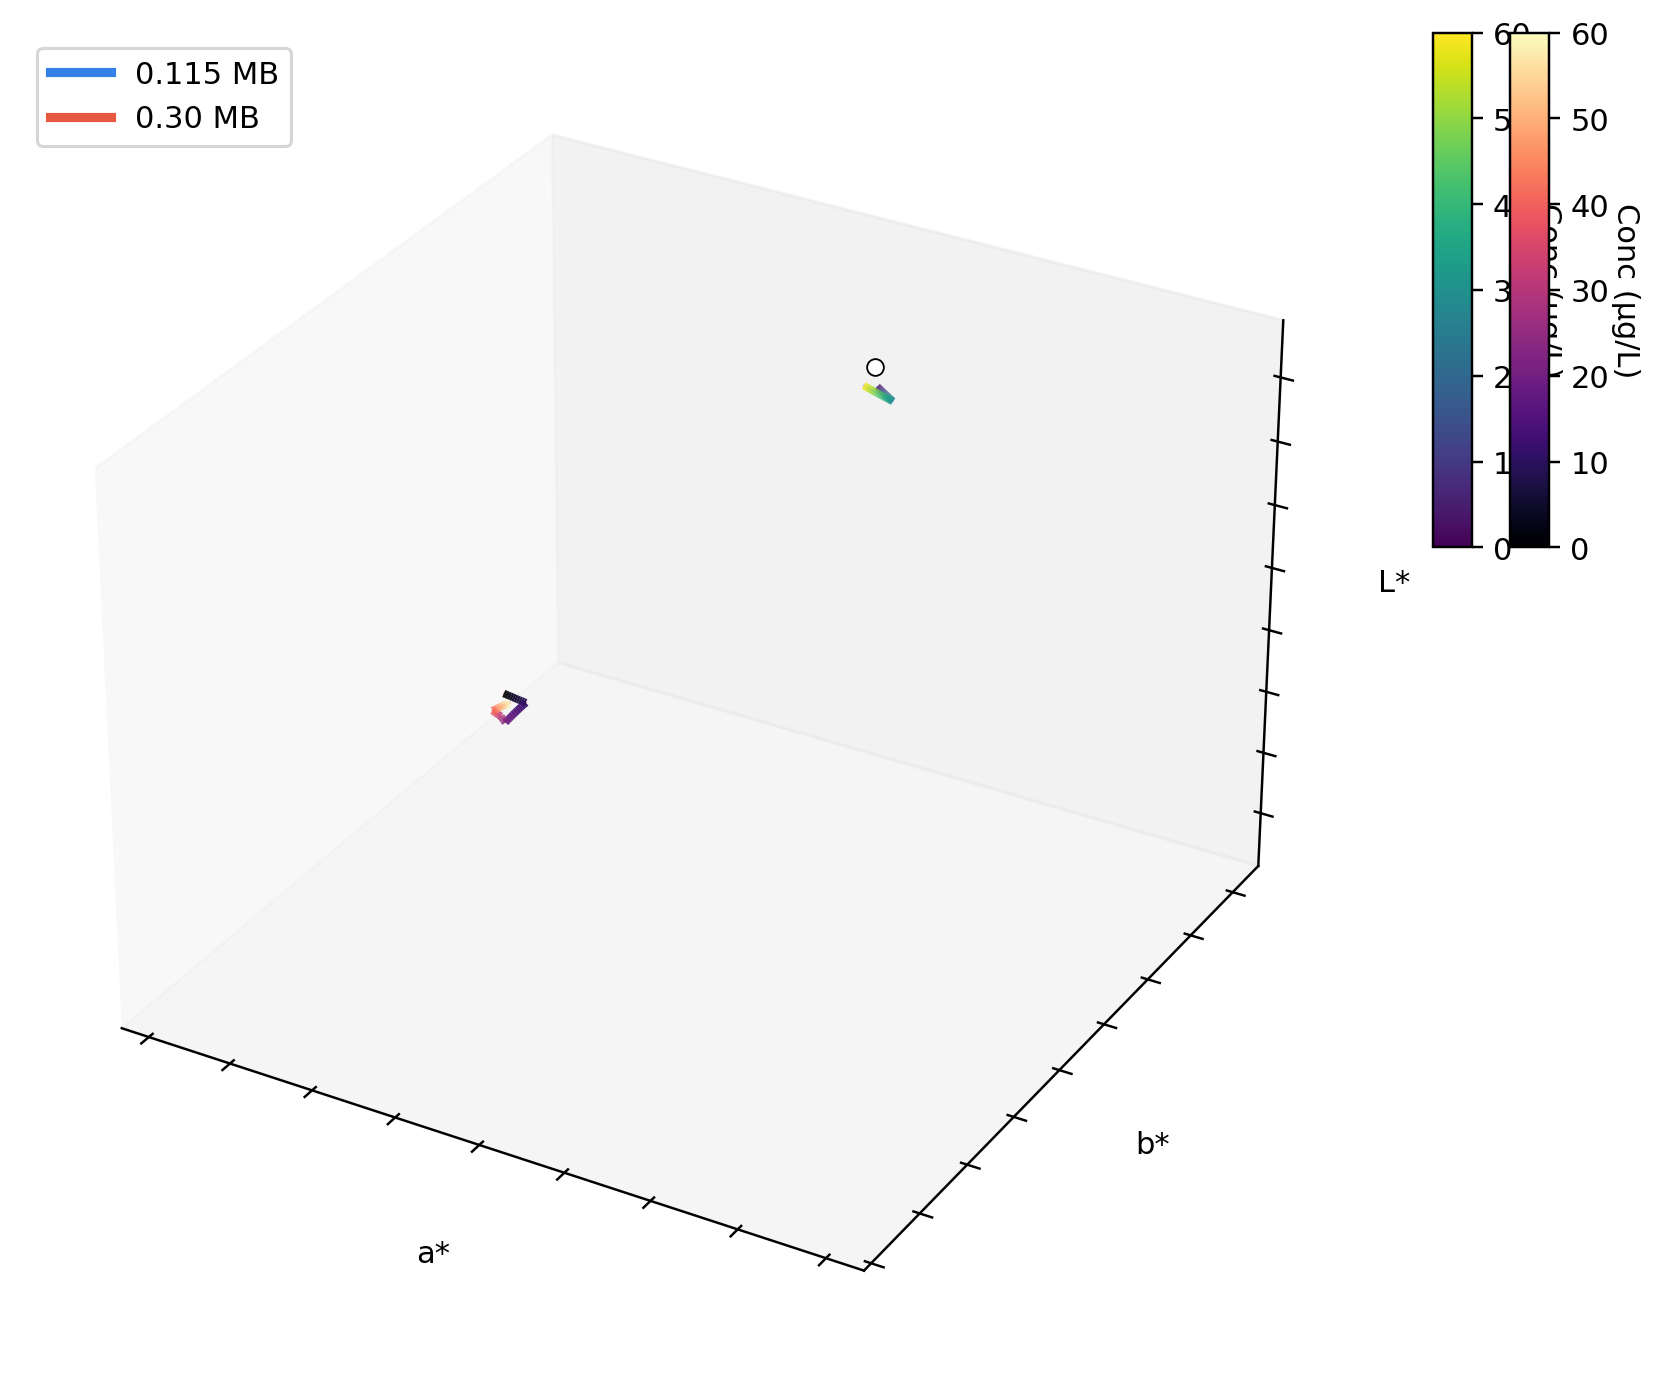

CIEDE2000-based trajectory metrics on shared grid
Mix        |   Arc length (ΣΔE00) |  Min adjacent ΔE00 |  Mean adjacent ΔE00 | % steps ≥ JND
------------------------------------------------------------------------------------------
0.115 MB   |               16.480 |              0.186 |               0.275 |            0%
0.30 MB    |               14.475 |              0.055 |               0.241 |            0%

Winner: 0.115 MB


In [15]:
# Color Trajectory Map in CIE Lab (3D) with ΔE00 metrics
# Shows which mix (0.115 MB vs 0.30 MB) travels farther and more smoothly in perceptual space

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm, colors
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS, XYZ_to_Lab
from colour.difference import delta_E

plt.rcParams.update({
    "figure.dpi": 220,
    "font.size": 10,
    "axes.facecolor": "white"
})

# ===== Inputs =====
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0           # T = 10^(-ABS_MULT * A)
GRID_STEP = 1.0          # shared concentration step
JND = 2.3

# Colour setup
cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

# ===== Helpers =====
def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns, "CSV must contain 'Wavelength'"
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()

    conc_vals = []
    for c in df.columns:
        if c == "Wavelength":
            continue
        try:
            conc_vals.append(float(c))
        except:
            pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    conc_cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in conc_cols], axis=1)
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def spectra_to_rgb(wavelengths, absorbance):
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def srgb_to_XYZ(rgb):
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    def inv_eotf(u):
        u = np.clip(u, 0, 1)
        return np.where(u <= 0.04045, u/12.92, ((u+0.055)/1.055)**2.4)
    lin = inv_eotf(rgb)
    return (M @ lin.T).T

def rgb_to_Lab_with_white(rgb_array, white_rgb):
    white_XYZ = srgb_to_XYZ(white_rgb)
    XYZ = srgb_to_XYZ(rgb_array)
    return XYZ_to_Lab(XYZ, white_XYZ)

def interpolate_A_over_c_grid(wl, conc_vals, A, c_grid):
    A_grid = np.vstack([np.interp(c_grid, conc_vals, A[i, :]) for i in range(A.shape[0])])
    return A_grid

def build_Lab_curve_on_grid(wl, conc_vals, A, c_grid):
    # white reference from lowest measured concentration in this file
    rgb_meas = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    idx0 = int(np.argmin(conc_vals))
    A_grid = interpolate_A_over_c_grid(wl, conc_vals, A, c_grid)
    rgb_grid = np.vstack([spectra_to_rgb(wl, A_grid[:, j]) for j in range(A_grid.shape[1])])
    Lab_grid = rgb_to_Lab_with_white(rgb_grid, rgb_meas[idx0])
    return Lab_grid, rgb_grid

def compute_metrics(c_grid, Lab_grid):
    # Adjacent ΔE00
    dE_adj = delta_E(Lab_grid[:-1], Lab_grid[1:], method="CIE 2000")
    # Arc length in perceptual space over the range
    arc_len = float(np.sum(dE_adj))
    # Stats
    min_adj = float(np.min(dE_adj)) if len(dE_adj) else np.nan
    mean_adj = float(np.mean(dE_adj)) if len(dE_adj) else np.nan
    pct_above = float(100*np.mean(dE_adj >= JND)) if len(dE_adj) else np.nan
    return dict(arc_length=arc_len, min_adj=min_adj, mean_adj=mean_adj, pct_above_JND=pct_above, dE_adj=dE_adj)

def segments_3d(x, y, z):
    pts = np.vstack([x, y, z]).T
    return np.stack([pts[:-1], pts[1:]], axis=1)

def set_axes_equal(ax):
    xs = ax.get_xlim3d(); ys = ax.get_ylim3d(); zs = ax.get_zlim3d()
    xmid = np.mean(xs); ymid = np.mean(ys); zmid = np.mean(zs)
    max_range = max(xs[1]-xs[0], ys[1]-ys[0], zs[1]-zs[0])
    r = max_range/2
    ax.set_xlim3d([xmid-r, xmid+r])
    ax.set_ylim3d([ymid-r, ymid+r])
    ax.set_zlim3d([zmid-r, zmid+r])

# ===== Load data, build shared grid, compute Lab curves =====
loaded = {name: load_measured_csv(path) for name, path in FILES.items()}
min0, max0 = loaded["0.115 MB"][1].min(), loaded["0.115 MB"][1].max()
min1, max1 = loaded["0.30 MB"][1].min(),  loaded["0.30 MB"][1].max()
c_lo, c_hi = max(min0, min1), min(max0, max1)
if not np.isfinite(c_lo) or not np.isfinite(c_hi) or c_hi <= c_lo:
    raise ValueError("No overlapping concentration range between the two mixes.")
c_grid = np.round(np.arange(c_lo, c_hi + 1e-9, GRID_STEP), 6)

curves = {}
metrics = {}
for name in FILES.keys():
    wl, conc_vals, A = loaded[name]
    Lab_curve, rgb_curve = build_Lab_curve_on_grid(wl, conc_vals, A, c_grid)
    curves[name] = dict(c=c_grid, Lab=Lab_curve, rgb=rgb_curve)
    metrics[name] = compute_metrics(c_grid, Lab_curve)

# ===== 3D rendering =====
fig = plt.figure(figsize=(8.8, 7.8))
ax = fig.add_subplot(111, projection="3d")
ax.grid(False)
for plane in [ax.xaxis, ax.yaxis, ax.zaxis]:
    for line in plane.get_gridlines():
        line.set_alpha(0.1)

# Common normalization for color along concentration
norm = colors.Normalize(vmin=c_grid.min(), vmax=c_grid.max())
cmap0 = cm.get_cmap("viridis")    # for 0.115 MB
cmap1 = cm.get_cmap("magma")      # for 0.30 MB
mix_styles = {
    "0.115 MB": dict(cmap=cmap0, color=(0.2, 0.5, 0.9)),
    "0.30 MB":  dict(cmap=cmap1, color=(0.9, 0.35, 0.25)),
}

for name, style in mix_styles.items():
    Lab = curves[name]["Lab"]
    cvals = curves[name]["c"]
    L, a, b = Lab[:, 0], Lab[:, 1], Lab[:, 2]
    segs = segments_3d(a, b, L)  # axes: a*, b*, L* for a familiar view
    # segment colors from concentration midpoints
    c_mid = 0.5*(cvals[:-1] + cvals[1:])
    seg_colors = style["cmap"](norm(c_mid))
    lc = Line3DCollection(segs, colors=seg_colors, linewidths=2.5, alpha=0.95)
    ax.add_collection(lc)
    # draw a thin neutral backbone for clarity
    ax.plot(a, b, L, color=style["color"], lw=0.8, alpha=0.4, solid_capstyle="round")

# White point marker near L*=100, a*=0, b*=0 for reference
ax.scatter([0], [0], [100], s=30, c="white", edgecolors="black", linewidths=0.6, zorder=5)

# Axes titles only, no tick labels to keep it clean
ax.set_xlabel("a*")
ax.set_ylabel("b*")
ax.set_zlabel("L*")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Legend
leg_handles = [
    plt.Line2D([0], [0], color=mix_styles["0.115 MB"]["color"], lw=3),
    plt.Line2D([0], [0], color=mix_styles["0.30 MB"]["color"], lw=3),
]
ax.legend(leg_handles, ["0.115 MB", "0.30 MB"], loc="upper left", frameon=True)

# Two compact vertical colorbars for concentration, one per mix
cax0 = fig.add_axes([0.90, 0.58, 0.02, 0.30])
cax1 = fig.add_axes([0.94, 0.58, 0.02, 0.30])
cb0 = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap0), cax=cax0)
cb1 = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap1), cax=cax1)
cb0.set_label("Conc (µg/L)", rotation=270, labelpad=10)
cb1.set_label("Conc (µg/L)", rotation=270, labelpad=10)

# Tight framing and equal-ish scale
set_axes_equal(ax)
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

# ===== Summary table and winner =====
print("CIEDE2000-based trajectory metrics on shared grid")
print(f"{'Mix':<10} | {'Arc length (ΣΔE00)':>20} | {'Min adjacent ΔE00':>18} | {'Mean adjacent ΔE00':>19} | {'% steps ≥ JND':>12}")
print("-"*90)
for name in FILES.keys():
    m = metrics[name]
    print(f"{name:<10} | {m['arc_length']:>20.3f} | {m['min_adj']:>18.3f} | {m['mean_adj']:>19.3f} | {m['pct_above_JND']:>12.0f}%")

def pick_winner(metrics_dict):
    # Primary: larger arc length. Tie-breakers: larger min_adj, then larger mean_adj, then higher %≥JND
    items = list(metrics_dict.items())
    def key_fn(item):
        m = item[1]
        return (-m['arc_length'], -m['min_adj'], -m['mean_adj'], -m['pct_above_JND'])
    items.sort(key=key_fn)
    return items[0][0]

print("\nWinner:", pick_winner(metrics))


In [16]:
# Side-by-side interactive 3D Lab trajectories with ΔE00 metrics (Plotly)

import numpy as np, pandas as pd
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS, XYZ_to_Lab
from colour.difference import delta_E
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ===== Inputs =====
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0
GRID_STEP = 1.0
JND = 2.3

cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()
    conc_vals = []
    for c in df.columns:
        if c == "Wavelength": continue
        try: conc_vals.append(float(c))
        except: pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in cols], axis=1)
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def spectra_to_rgb(wavelengths, absorbance):
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def srgb_to_XYZ(rgb):
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    def inv_eotf(u):
        u = np.clip(u, 0, 1)
        return np.where(u <= 0.04045, u/12.92, ((u+0.055)/1.055)**2.4)
    lin = inv_eotf(rgb)
    return (M @ lin.T).T

def rgb_to_Lab_with_white(rgb_array, white_rgb):
    white_XYZ = srgb_to_XYZ(white_rgb)
    XYZ = srgb_to_XYZ(rgb_array)
    return XYZ_to_Lab(XYZ, white_XYZ)

def curve_on_grid(wl, conc_vals, A, c_grid):
    # white reference from lowest measured conc
    rgb_meas = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    idx0 = int(np.argmin(conc_vals))
    A_grid = np.vstack([np.interp(c_grid, conc_vals, A[i,:]) for i in range(A.shape[0])])
    rgb_grid = np.vstack([spectra_to_rgb(wl, A_grid[:, j]) for j in range(A_grid.shape[1])])
    Lab_grid = rgb_to_Lab_with_white(rgb_grid, rgb_meas[idx0])
    return Lab_grid, rgb_grid

def metrics_from_curve(Lab_grid):
    dE_adj = delta_E(Lab_grid[:-1], Lab_grid[1:], method="CIE 2000")
    return dict(
        arc_length=float(np.sum(dE_adj)),
        min_adj=float(np.min(dE_adj)) if len(dE_adj) else float("nan"),
        mean_adj=float(np.mean(dE_adj)) if len(dE_adj) else float("nan"),
        pct_above_JND=float(100*np.mean(dE_adj >= JND)) if len(dE_adj) else float("nan"),
        dE_adj=dE_adj
    )

# Load both, derive overlap, build shared grid for fair stats
loaded = {k: load_measured_csv(v) for k,v in FILES.items()}
mn0,mx0 = loaded["0.115 MB"][1].min(), loaded["0.115 MB"][1].max()
mn1,mx1 = loaded["0.30 MB"][1].min(),  loaded["0.30 MB"][1].max()
c_lo, c_hi = max(mn0,mn1), min(mx0,mx1)
if not np.isfinite(c_lo) or not np.isfinite(c_hi) or c_hi <= c_lo:
    raise ValueError("No overlapping concentration range.")
c_grid = np.round(np.arange(c_lo, c_hi + 1e-9, GRID_STEP), 6)

curves, metrics = {}, {}
for name in FILES:
    wl, conc, A = loaded[name]
    Lab, rgb = curve_on_grid(wl, conc, A, c_grid)
    curves[name] = dict(c=c_grid, Lab=Lab, rgb=rgb)
    metrics[name] = metrics_from_curve(Lab)

# Build side-by-side interactive 3D
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type":"scene"}, {"type":"scene"}]],
                    horizontal_spacing=0.06)

scene_titles = {"0.115 MB": "0.115 MB", "0.30 MB": "0.30 MB"}
cmaps = {"0.115 MB":"Viridis", "0.30 MB":"Magma"}  # Plotly built-ins

for i, name in enumerate(["0.115 MB","0.30 MB"], start=1):
    Lab = curves[name]["Lab"]; cvals = curves[name]["c"]
    L, a, b = Lab[:,0], Lab[:,1], Lab[:,2]
    # color by concentration along path
    fig.add_trace(go.Scatter3d(
        x=a, y=b, z=L,
        mode="lines",
        line=dict(width=6, color=cvals, colorscale=cmaps[name]),
        hoverinfo="skip",
        showlegend=False
    ), row=1, col=i)
    # white point marker
    fig.add_trace(go.Scatter3d(
        x=[0], y=[0], z=[100],
        mode="markers",
        marker=dict(size=3, color="white", line=dict(color="black", width=1)),
        hoverinfo="skip",
        showlegend=False
    ), row=1, col=i)
    fig.update_scenes(
        xaxis_title="a*",
        yaxis_title="b*",
        zaxis_title="L*",
        xaxis=dict(showgrid=True, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=True, zeroline=False, showticklabels=False),
        zaxis=dict(showgrid=True, zeroline=False, showticklabels=False),
        aspectmode="data",
        bgcolor="rgba(255,255,255,1)",
        row=1, col=i
    )
    # individual colorbar
    fig.update_traces(selector=dict(row=1, col=i, type="scatter3d"),
                      colorbar=dict(title="Conc (µg/L)"), row=1, col=i)
    fig.layout.annotations += (dict(text=scene_titles[name], x=0.25 if i==1 else 0.88,
                                    y=1.08, xref="paper", yref="paper",
                                    showarrow=False, font=dict(size=14)),)

fig.update_layout(
    margin=dict(l=0, r=0, t=60, b=0),
    template="plotly_white"
)

fig.show()

# Print compact metrics
print("CIEDE2000 trajectory metrics on shared range")
print(f"{'Mix':<10} | {'Arc length (ΣΔE00)':>20} | {'Min ΔE00':>10} | {'Mean ΔE00':>11} | {'% steps ≥ JND':>12}")
print("-"*70)
for name in FILES:
    m = metrics[name]
    print(f"{name:<10} | {m['arc_length']:>20.3f} | {m['min_adj']:>10.3f} | {m['mean_adj']:>11.3f} | {m['pct_above_JND']:>12.0f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CIEDE2000 trajectory metrics on shared range
Mix        |   Arc length (ΣΔE00) |   Min ΔE00 |   Mean ΔE00 | % steps ≥ JND
----------------------------------------------------------------------
0.115 MB   |               16.480 |      0.186 |       0.275 |            0%
0.30 MB    |               14.475 |      0.055 |       0.241 |            0%


In [17]:
# Side-by-side interactive 3D Lab "planes" built from dense interpolation
# Each mix gets a thin ribbon surface plus tiny points along the path

import numpy as np, pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS, XYZ_to_Lab
from colour.difference import delta_E

# ===== Inputs =====
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0
GRID_STEP_FINE = 0.25     # dense sampling across concentration
RIBBON_HALF_WIDTH = 0.6   # Lab-units half-width of the ribbon
RIBBON_SLICES = 7         # cross-ribbon samples
JND = 2.3

cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()
    conc_vals = []
    for c in df.columns:
        if c == "Wavelength": continue
        try: conc_vals.append(float(c))
        except: pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in cols], axis=1)
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def spectra_to_rgb(wavelengths, absorbance):
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    rgb = np.clip(XYZ_to_sRGB(XYZ), 0, 1)
    return rgb

def srgb_to_XYZ(rgb):
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    def inv_eotf(u):
        u = np.clip(u, 0, 1)
        return np.where(u <= 0.04045, u/12.92, ((u+0.055)/1.055)**2.4)
    lin = inv_eotf(rgb)
    return (M @ lin.T).T

def rgb_to_Lab_with_white(rgb_array, white_rgb):
    white_XYZ = srgb_to_XYZ(white_rgb)
    XYZ = srgb_to_XYZ(rgb_array)
    return XYZ_to_Lab(XYZ, white_XYZ)

def build_curve(wl, conc_vals, A, c_grid):
    rgb_meas = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    idx0 = int(np.argmin(conc_vals))
    A_grid = np.vstack([np.interp(c_grid, conc_vals, A[i,:]) for i in range(A.shape[0])])
    rgb_grid = np.vstack([spectra_to_rgb(wl, A_grid[:, j]) for j in range(A_grid.shape[1])])
    Lab_grid = rgb_to_Lab_with_white(rgb_grid, rgb_meas[idx0])
    return Lab_grid

def metrics_from_curve(Lab_grid):
    dE_adj = delta_E(Lab_grid[:-1], Lab_grid[1:], method="CIE 2000")
    return dict(
        arc_length=float(np.sum(dE_adj)),
        min_adj=float(np.min(dE_adj)) if len(dE_adj) else float("nan"),
        mean_adj=float(np.mean(dE_adj)) if len(dE_adj) else float("nan"),
        pct_above_JND=float(100*np.mean(dE_adj >= JND)) if len(dE_adj) else float("nan")
    )

def ribbon_surface_from_curve(Lab, half_width=0.6, slices=7):
    # Build an orthonormal direction perpendicular to the tangent
    L, a, b = Lab[:,0], Lab[:,1], Lab[:,2]
    dLab = np.gradient(Lab, axis=0)
    # choose a stable helper vector then Gram-Schmidt
    helper = np.array([0,0,1.0])
    normals = []
    for t in dLab:
        v = t / (np.linalg.norm(t) + 1e-12)
        n = helper - v*np.dot(helper, v)
        if np.linalg.norm(n) < 1e-6:
            helper = np.array([1.0,0,0])  # fallback if parallel
            n = helper - v*np.dot(helper, v)
        n = n / (np.linalg.norm(n) + 1e-12)
        normals.append(n)
    normals = np.vstack(normals)  # [N,3]

    # cross section offsets across ribbon
    u = np.linspace(-1, 1, slices) * half_width
    # build mesh
    Lm = (L[:,None] + normals[:,0:1]*0) + u*normals[:,0:1]  # use n_L component
    am = (a[:,None] + u*normals[:,1:2])
    bm = (b[:,None] + u*normals[:,2:3])

    # Plotly surface expects 2D arrays shaped [len(c), slices]
    return am, bm, Lm

# Load, compute overlap, dense grid
loaded = {k: load_measured_csv(v) for k,v in FILES.items()}
mn0,mx0 = loaded["0.115 MB"][1].min(), loaded["0.115 MB"][1].max()
mn1,mx1 = loaded["0.30 MB"][1].min(),  loaded["0.30 MB"][1].max()
c_lo, c_hi = max(mn0,mn1), min(mx0,mx1)
if not np.isfinite(c_lo) or not np.isfinite(c_hi) or c_hi <= c_lo:
    raise ValueError("No overlapping concentration range.")
c_grid = np.round(np.arange(c_lo, c_hi + 1e-9, GRID_STEP_FINE), 6)

curves, stats = {}, {}
for name in FILES:
    wl, conc, A = loaded[name]
    Lab = build_curve(wl, conc, A, c_grid)
    curves[name] = dict(Lab=Lab, c=c_grid)
    stats[name] = metrics_from_curve(Lab)

# Build side-by-side figure
fig = make_subplots(rows=1, cols=2, specs=[[{"type":"scene"},{"type":"scene"}]], horizontal_spacing=0.06)

cmaps = {"0.115 MB":"Viridis", "0.30 MB":"Magma"}

for i, name in enumerate(["0.115 MB","0.30 MB"], start=1):
    Lab = curves[name]["Lab"]; cvals = curves[name]["c"]
    L, a, b = Lab[:,0], Lab[:,1], Lab[:,2]

    # ribbon surface
    A_surf, B_surf, L_surf = ribbon_surface_from_curve(Lab, half_width=RIBBON_HALF_WIDTH, slices=RIBBON_SLICES)
    # surfacecolor by concentration replicated across slices
    C_surf = np.tile(cvals[:,None], (1, RIBBON_SLICES))

    fig.add_trace(go.Surface(
        x=A_surf, y=B_surf, z=L_surf,
        surfacecolor=C_surf,
        colorscale=cmaps[name],
        cmin=cvals.min(), cmax=cvals.max(),
        showscale=True,
        colorbar=dict(title="Conc (µg/L)"),
        opacity=0.92
    ), row=1, col=i)

    # tiny points along the centerline
    fig.add_trace(go.Scatter3d(
        x=a, y=b, z=L,
        mode="markers",
        marker=dict(size=2, color="black"),
        hoverinfo="skip",
        showlegend=False
    ), row=1, col=i)

    # white point
    fig.add_trace(go.Scatter3d(
        x=[0], y=[0], z=[100],
        mode="markers",
        marker=dict(size=3, color="white", line=dict(color="black", width=1)),
        hoverinfo="skip",
        showlegend=False
    ), row=1, col=i)

    # scene styling
    fig.update_scenes(
        xaxis_title="a*", yaxis_title="b*", zaxis_title="L*",
        xaxis=dict(showgrid=True, showticklabels=False, zeroline=False),
        yaxis=dict(showgrid=True, showticklabels=False, zeroline=False),
        zaxis=dict(showgrid=True, showticklabels=False, zeroline=False),
        aspectmode="data",
        bgcolor="rgba(255,255,255,1)",
        row=1, col=i
    )
    fig.layout.annotations += (dict(text=name, x=0.25 if i==1 else 0.88,
                                    y=1.06, xref="paper", yref="paper",
                                    showarrow=False, font=dict(size=14)),)

fig.update_layout(margin=dict(l=0, r=0, t=50, b=0), template="plotly_white")
fig.show()

# Print compact ΔE00 metrics
print("CIEDE2000 trajectory metrics on shared range")
print(f"{'Mix':<10} | {'Arc length (ΣΔE00)':>20} | {'Min ΔE00':>10} | {'Mean ΔE00':>11} | {'% steps ≥ JND':>12}")
print("-"*70)
for name in FILES:
    m = stats[name]
    print(f"{name:<10} | {m['arc_length']:>20.3f} | {m['min_adj']:>10.3f} | {m['mean_adj']:>11.3f} | {m['pct_above_JND']:>12.0f}%")


CIEDE2000 trajectory metrics on shared range
Mix        |   Arc length (ΣΔE00) |   Min ΔE00 |   Mean ΔE00 | % steps ≥ JND
----------------------------------------------------------------------
0.115 MB   |               16.479 |      0.046 |       0.069 |            0%
0.30 MB    |               14.475 |      0.014 |       0.060 |            0%


In [18]:
# Filled 2D planes in CIE Lab with dense interpolated points
# Side-by-side Plotly scenes, cubic axes per scene, white point shown

import numpy as np, pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from numpy.linalg import svd, norm
from colour import SpectralDistribution, sd_to_XYZ, XYZ_to_sRGB, MSDS_CMFS, SDS_ILLUMINANTS, XYZ_to_Lab
from colour.difference import delta_E

# ===== Inputs =====
FILES = {
    "0.115 MB": "/content/drive/MyDrive/RegeneronSTS/data/0.115MB_AuNP_As.csv",
    "0.30 MB":  "/content/drive/MyDrive/RegeneronSTS/data/0.30MB_AuNP_As.csv",
}
WL_MIN, WL_MAX = 380, 780
ABS_MULT = 4.0
GRID_STEP = 0.25        # dense concentration sampling
PLANE_WIDTH_FRAC = 0.18 # plane half-width as fraction of main in-plane span
JND = 2.3

cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
illuminant = SDS_ILLUMINANTS['D65']

# ===== Helpers =====
def load_measured_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.map(str).str.strip()
    assert "Wavelength" in df.columns
    df["Wavelength"] = pd.to_numeric(df["Wavelength"], errors="coerce")
    df = df.dropna(subset=["Wavelength"]).sort_values("Wavelength")
    df = df[(df["Wavelength"] >= WL_MIN) & (df["Wavelength"] <= WL_MAX)].copy()
    conc_vals = []
    for c in df.columns:
        if c == "Wavelength": continue
        try: conc_vals.append(float(c))
        except: pass
    conc_vals = np.array(sorted(conc_vals), dtype=float)
    cols = [str(int(c)) if float(c).is_integer() else str(c) for c in conc_vals]
    A = np.stack([pd.to_numeric(df[c], errors="coerce").to_numpy() for c in cols], axis=1)
    wl = df["Wavelength"].to_numpy().astype(float)
    return wl, conc_vals, A

def spectra_to_rgb(wavelengths, absorbance):
    T = 10.0 ** (-ABS_MULT * np.asarray(absorbance))
    sd = SpectralDistribution(dict(zip(wavelengths, T)))
    XYZ = sd_to_XYZ(sd, cmfs, illuminant) / 100.0
    return np.clip(XYZ_to_sRGB(XYZ), 0, 1)

def srgb_to_XYZ(rgb):
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    def inv_eotf(u):
        u = np.clip(u, 0, 1)
        return np.where(u <= 0.04045, u/12.92, ((u+0.055)/1.055)**2.4)
    lin = inv_eotf(rgb)
    return (M @ lin.T).T

def rgb_to_Lab_with_white(rgb_array, white_rgb):
    white_XYZ = srgb_to_XYZ(white_rgb)
    XYZ = srgb_to_XYZ(rgb_array)
    return XYZ_to_Lab(XYZ, white_XYZ)

def curve_Lab_on_grid(wl, conc_vals, A, c_grid):
    # white = lowest measured conc in this file
    rgb_meas = np.vstack([spectra_to_rgb(wl, A[:, j]) for j in range(A.shape[1])])
    idx0 = int(np.argmin(conc_vals))
    A_grid = np.vstack([np.interp(c_grid, conc_vals, A[i,:]) for i in range(A.shape[0])])
    rgb_grid = np.vstack([spectra_to_rgb(wl, A_grid[:, j]) for j in range(A_grid.shape[1])])
    Lab_grid = rgb_to_Lab_with_white(rgb_grid, rgb_meas[idx0])
    return Lab_grid

def pca_plane(points3):
    # points3: [N,3] in Lab order [L*, a*, b*]
    mu = points3.mean(0)
    X = points3 - mu
    U, S, Vt = svd(X, full_matrices=False)  # Vt rows are PCs in Lab basis
    v1, v2 = Vt[0], Vt[1]                   # in-plane
    return mu, v1, v2

def plane_mesh(mu, v1, v2, s1_min, s1_max, width, n_s=60, n_t=30):
    # build rectangle in the PCA plane: s along v1, t across v2
    s = np.linspace(s1_min, s1_max, n_s)
    t = np.linspace(-width, width, n_t)
    S, T = np.meshgrid(s, t, indexing="xy")
    P = mu + S[...,None]*v1 + T[...,None]*v2
    # return in a*, b*, L* order for Plotly axes x=a*, y=b*, z=L*
    a = P[...,1]; b = P[...,2]; L = P[...,0]
    return a, b, L

def tight_cube_ranges(x, y, z, pad=0.02):
    x0,x1 = np.min(x), np.max(x)
    y0,y1 = np.min(y), np.max(y)
    z0,z1 = np.min(z), np.max(z)
    cx, cy, cz = (x0+x1)/2, (y0+y1)/2, (z0+z1)/2
    span = max(x1-x0, y1-y0, z1-z0)
    r = span/2 * (1+pad)
    return [cx-r, cx+r], [cy-r, cy+r], [cz-r, cz+r]

def metrics_from_curve(Lab):
    dE_adj = delta_E(Lab[:-1], Lab[1:], method="CIE 2000")
    return dict(
        arc_length=float(np.sum(dE_adj)),
        min_adj=float(np.min(dE_adj)) if len(dE_adj) else float("nan"),
        mean_adj=float(np.mean(dE_adj)) if len(dE_adj) else float("nan"),
        pct_above_JND=float(100*np.mean(dE_adj >= JND)) if len(dE_adj) else float("nan")
    )

# ===== Load both, overlap range, dense grid =====
loaded = {k: load_measured_csv(v) for k,v in FILES.items()}
mn0,mx0 = loaded["0.115 MB"][1].min(), loaded["0.115 MB"][1].max()
mn1,mx1 = loaded["0.30 MB"][1].min(),  loaded["0.30 MB"][1].max()
c_lo, c_hi = max(mn0,mn1), min(mx0,mx1)
if not np.isfinite(c_lo) or not np.isfinite(c_hi) or c_hi <= c_lo:
    raise ValueError("No overlapping concentration range.")
c_grid = np.round(np.arange(c_lo, c_hi + 1e-9, GRID_STEP), 6)

curves = {}
stats = {}
for name in FILES:
    wl, conc, A = loaded[name]
    Lab = curve_Lab_on_grid(wl, conc, A, c_grid)         # [N,3] in L*,a*,b*
    curves[name] = dict(Lab=Lab, c=c_grid)
    stats[name] = metrics_from_curve(Lab)

# ===== Build side-by-side planes + points =====
fig = make_subplots(rows=1, cols=2, specs=[[{"type":"scene"},{"type":"scene"}]], horizontal_spacing=0.06)

cs_map = {"0.115 MB":"Viridis", "0.30 MB":"Magma"}

for i, name in enumerate(["0.115 MB","0.30 MB"], start=1):
    Lab = curves[name]["Lab"]; cvals = curves[name]["c"]
    # PCA plane
    mu, v1, v2 = pca_plane(Lab[:, [0,1,2]])       # [L,a,b]
    # project to in-plane s1 range to size the plane
    X = Lab[:, [0,1,2]] - mu
    s1 = X @ v1
    s_min, s_max = s1.min(), s1.max()
    width = PLANE_WIDTH_FRAC * (s_max - s_min + 1e-9)

    # plane mesh
    Aplane, Bplane, Lplane = plane_mesh(mu, v1, v2, s_min, s_max, width, n_s=80, n_t=60)
    # plane surface (light grey)
    fig.add_trace(go.Surface(
        x=Aplane, y=Bplane, z=Lplane,
        showscale=False, opacity=0.25, colorscale="Greys"
    ), row=1, col=i)

    # interpolated points on top, colored by concentration
    a_pts, b_pts, L_pts = Lab[:,1], Lab[:,2], Lab[:,0]
    fig.add_trace(go.Scatter3d(
        x=a_pts, y=b_pts, z=L_pts,
        mode="markers",
        marker=dict(size=3, color=cvals, colorscale=cs_map[name], colorbar=dict(title="Conc (µg/L)")),
        hoverinfo="skip", showlegend=False
    ), row=1, col=i)

    # white point
    fig.add_trace(go.Scatter3d(
        x=[0], y=[0], z=[100],
        mode="markers",
        marker=dict(size=4, color="white", line=dict(color="black", width=1)),
        hoverinfo="skip", showlegend=False
    ), row=1, col=i)

    # cubic ranges as small as possible around data + plane
    xr, yr, zr = tight_cube_ranges(np.r_[Aplane.ravel(), a_pts], np.r_[Bplane.ravel(), b_pts], np.r_[Lplane.ravel(), L_pts])
    fig.update_scenes(
        xaxis_title="a*", yaxis_title="b*", zaxis_title="L*",
        xaxis=dict(range=xr, showticklabels=False, showgrid=True, zeroline=False),
        yaxis=dict(range=yr, showticklabels=False, showgrid=True, zeroline=False),
        zaxis=dict(range=zr, showticklabels=False, showgrid=True, zeroline=False),
        aspectmode="cube", bgcolor="rgba(255,255,255,1)",
        row=1, col=i
    )
    fig.layout.annotations += (dict(text=name, x=0.25 if i==1 else 0.88,
                                    y=1.06, xref="paper", yref="paper",
                                    showarrow=False, font=dict(size=14)),)

fig.update_layout(margin=dict(l=0, r=0, t=50, b=0), template="plotly_white")
fig.show()

# ===== Compact ΔE00 metrics =====
print("CIEDE2000 trajectory metrics on shared range")
print(f"{'Mix':<10} | {'Arc length (ΣΔE00)':>20} | {'Min ΔE00':>10} | {'Mean ΔE00':>11} | {'% steps ≥ JND':>12}")
print("-"*70)
for name in FILES:
    m = stats[name]
    print(f"{name:<10} | {m['arc_length']:>20.3f} | {m['min_adj']:>10.3f} | {m['mean_adj']:>11.3f} | {m['pct_above_JND']:>12.0f}%")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CIEDE2000 trajectory metrics on shared range
Mix        |   Arc length (ΣΔE00) |   Min ΔE00 |   Mean ΔE00 | % steps ≥ JND
----------------------------------------------------------------------
0.115 MB   |               16.479 |      0.046 |       0.069 |            0%
0.30 MB    |               14.475 |      0.014 |       0.060 |            0%
